In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from aerometrics.utils.functions import emission_profile_function
from aerometrics.metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from aerometrics.climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from aerometrics.climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from aerometrics.climate_models.lwe_climate_model import species_lwe_climate_model
from aerometrics.climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

## Parameters

In [2]:
co2_method = 'FaIR'
start_year = 1765
t0 = 2020
time_horizon = 100
end_year = t0 + time_horizon

## Metrics calculation

In [3]:
decade_number = 16  # Numerical problem for CO2 after this level of emissions

j = 0
gwp_rf = np.zeros((decade_number,7))
gwp_erf = np.zeros((decade_number,7))
egwp_rf = np.zeros((decade_number,7))
egwp_erf = np.zeros((decade_number,7))
gtp = np.zeros((decade_number,7))
igtp = np.zeros((decade_number,7))
ratr = np.zeros((decade_number,7))

for species in ["Aviation CO2", "Aviation contrails", "Aviation NOx - ST O3 increase", "Aviation NOx - CH4 decrease and induced", "Aviation H2O", "Aviation soot", "Aviation sulfur"]:
    
    if species == "Aviation CO2":
        sensitivity_rf = 9.2e-16 # Not used with FaIR
        ratio_erf_rf = 1
        efficacy_erf = 1
    elif species == "Aviation contrails":
        sensitivity_rf = 2.23e-12
        ratio_erf_rf = 0.42
        efficacy_erf = 1
    elif species == "Aviation NOx - ST O3 increase":
        sensitivity_rf = 25.1e-12 * (14/46)
        ratio_erf_rf = 1.37
        efficacy_erf = 1
    elif species == "Aviation NOx - CH4 decrease and induced":
        sensitivity_rf = -3.90
        ratio_erf_rf = 1.18
        efficacy_erf = 1
    elif species == "Aviation H2O":
        sensitivity_rf = 0.0052e-12
        ratio_erf_rf = 1
        efficacy_erf = 1
    elif species == "Aviation soot":
        sensitivity_rf = 100.7e-12 # Not used
        ratio_erf_rf = 1
        efficacy_erf = 1
    elif species == "Aviation sulfur":
        sensitivity_rf = -19.9e-12 # Not used
        ratio_erf_rf = 1
        efficacy_erf = 1
        
    for k in range(0,decade_number):
        unit_value = 1*10**k # [kg] or [km] for contrails
        
        background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
        emission_profile = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value)
        
        if co2_method == 'IPCC':
            unit_value_co2 = 1
            radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = co2_ipcc_climate_model(start_year, end_year, unit_value_co2)
            radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = co2_ipcc_pulse_absolute_metrics(time_horizon)
        elif co2_method == 'FaIR':
            sensitivity_rf_co2 = 9.2e-16 # # Not used with FaIR
            ratio_erf_rf_co2 = 1
            efficacy_erf_co2 = 1
            emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value)
            species_settings_co2 = {"sensitivity_rf": sensitivity_rf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}
            model_settings_co2 = {"background_species_quantities": background_species_quantities}
            radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
            radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value, effective_radiative_forcing_co2/unit_value, temperature_co2/unit_value
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
        
        species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
        model_settings = {"background_species_quantities": background_species_quantities}
        radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
        agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)
                
        gwp_rf[k,j], gwp_erf[k,j], egwp_rf[k,j], egwp_erf[k,j], gtp[k,j], igtp[k,j], ratr[k,j] = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
        
    j +=1

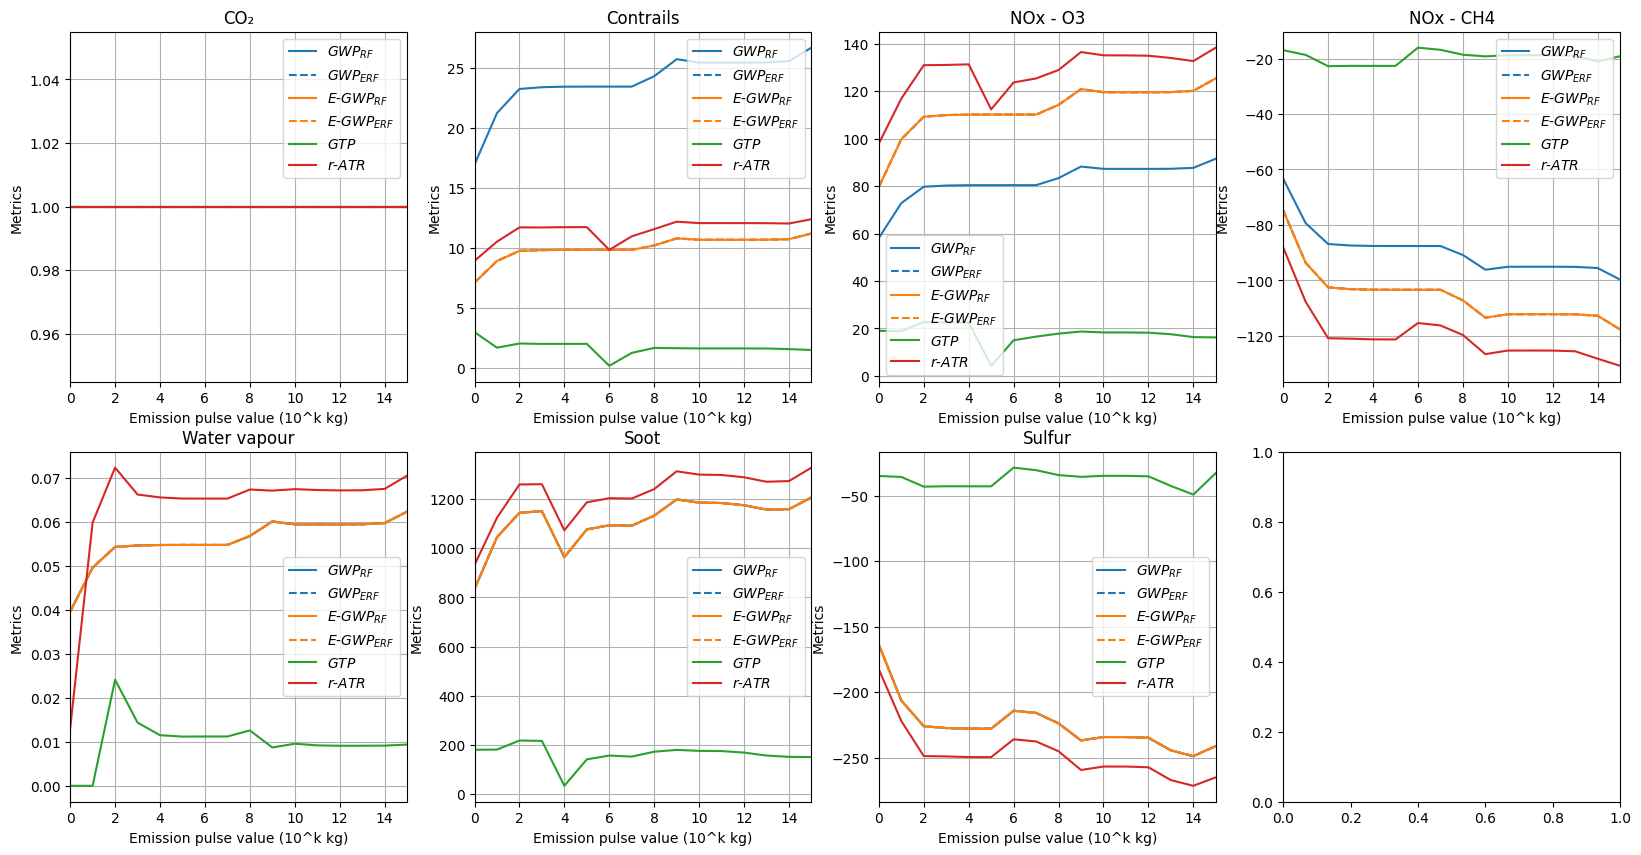

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    if i != 7:
        x_axis = range(0, len(gwp_rf[:, i]))
        ax.plot(x_axis, gwp_rf[:, i], label=r'$GWP_{RF}$', color='C0')
        ax.plot(x_axis, gwp_erf[:, i], label=r'$GWP_{ERF}$', color='C0', linestyle='--')
        ax.plot(x_axis, egwp_rf[:, i], label=r'$E\text{-}GWP_{RF}$', color='C1')
        ax.plot(x_axis, egwp_erf[:, i], label=r'$E\text{-}GWP_{ERF}$', color='C1', linestyle='--')
        ax.plot(x_axis, gtp[:, i], label=r'$GTP$', color='C2')
        ax.plot(x_axis, ratr[:, i], label=r'$r\text{-}ATR$', color='C3')
        ax.set_xlim(0,len(gwp_rf[:, i])-1)
        ax.set_xlabel('Emission pulse value (10^k kg)')
        ax.set_ylabel('Metrics')
        if i == 0:
            ax.set_title('CO₂')
        elif i == 1:
            ax.set_title('Contrails')
        elif i == 2:
            ax.set_title('NOx - O3')
        elif i == 3:
            ax.set_title('NOx - CH4')
        elif i == 4:
            ax.set_title('Water vapour')
        elif i == 5:
            ax.set_title('Soot')
        elif i == 6:
            ax.set_title('Sulfur')
        ax.grid()
        ax.legend()
    
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()